# E-commerce analysis


## Overview
Our machine learning project is based on analysis of the Brazilian E-Commerce Public Dataset by Olist. This dataset contains information on e-commerce transactions in Brazil collected by Olist from 2016 to 2018. It includes various aspects of transactions, including information about products, buyers, sellers and delivery.

### Expected results

Our project is expected to lead to the development of a range of machine learning models capable of predicting various aspects of e-commerce with high accuracy. These models can be useful for optimizing business processes, improving customer service, and increasing Olist's operational efficiency.

### Sources

- [Presentation](https://docs.google.com/presentation/d/1n4XlzflNo-KMZxXFLD1iwhmwaR70d4vxNukqeMVgfvs/edit?usp=sharing)
- [Dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)


## Our team

Members of team #5:

1. [Danila Zaitcev](https://github.com/DanilaZaitcev/StatPrak24)
2. [Erik Rusanov](https://github.com/ErikRusanov/statistics)
3. [Maksim Malyshev](https://github.com/Solidniy63/StatPrak_Malyshev)
4. [Maria Rodionova](https://github.com/RodionovaMR/statprak) 


## Quick start

- Download **Dataset** from sources
- Put the correct paths
- Click `Run all` 

In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

CUSTOMERS_PATH = "./datasets/olist_customers_dataset.csv"
ORDERS_PATH = "./datasets/olist_orders_dataset.csv"
ORDER_ITEMS_PATH = "./datasets/olist_order_items_dataset.csv"
ORDER_PAYMENTS_PATH = "./datasets/olist_order_payments_dataset.csv"

FIG_SIZE = (12, 8)
MAIN_COLOR = "#674ea7"

In [86]:
customers = pd.read_csv(CUSTOMERS_PATH)
orders = pd.read_csv(ORDERS_PATH)
order_items = pd.read_csv(ORDER_ITEMS_PATH)
order_payments = pd.read_csv(ORDER_PAYMENTS_PATH)

In [87]:
data = pd.merge(orders, customers, on="customer_id")
data = pd.merge(data, order_items[["order_id", "order_item_id"]], on="order_id")
data = pd.merge(data, order_payments[["order_id", "payment_type"]], on="order_id")

data.drop(
    ["order_approved_at", "order_delivered_carrier_date", "order_estimated_delivery_date"],
    axis=1,
    inplace=True
)

In [88]:
data["order_purchase_timestamp"] = pd.to_datetime(data["order_purchase_timestamp"])
data["order_delivered_customer_date"] = pd.to_datetime(data["order_delivered_customer_date"])
data["delivery_time"] = (data["order_delivered_customer_date"] - data["order_purchase_timestamp"]).dt.days

In [89]:
Q1 = data["delivery_time"].quantile(0.25)
Q3 = data["delivery_time"].quantile(0.75)
IQR = Q3 - Q1
data = data[(data["delivery_time"] >= (Q1 - 1.5 * IQR)) & (data["delivery_time"] <= (Q3 + 1.5 * IQR))]

In [90]:
total_items = order_items.groupby("order_id").size().reset_index(name="total_items")
data = pd.merge(data, total_items, on="order_id")
data.dropna(inplace=True)

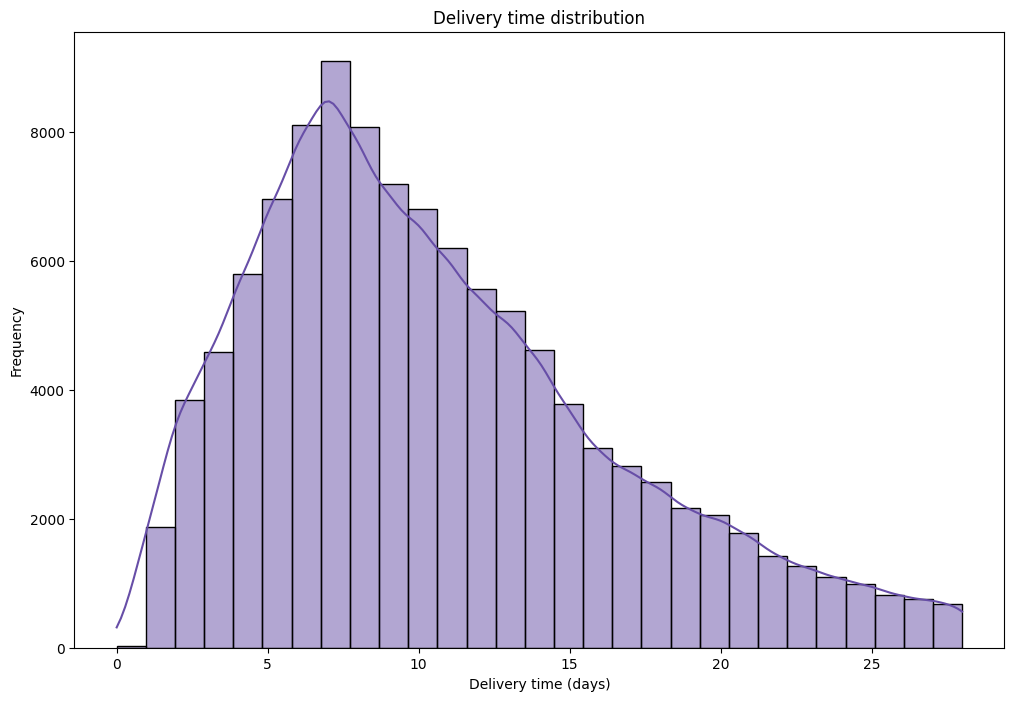

In [91]:
plt.figure(figsize=FIG_SIZE)
sns.histplot(
    data["delivery_time"],
    bins=len(data["delivery_time"].value_counts()),
    kde=True,
    color=MAIN_COLOR
)
plt.title("Delivery time distribution")
plt.xlabel("Delivery time (days)")
plt.ylabel("Frequency")
plt.show()

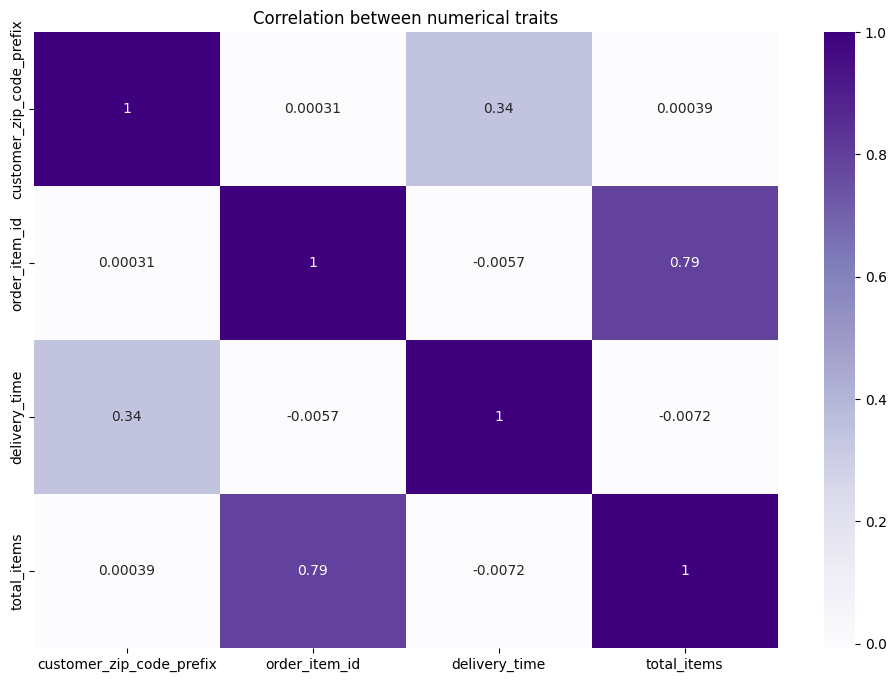

In [92]:
dummies = pd.get_dummies(data, columns=["customer_state"])

numeric_columns = dummies.select_dtypes(include=["number"]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(dummies[numeric_columns].corr(), annot=True, cmap="Purples")
plt.title("Correlation between numerical traits")
plt.show()

In [93]:
X = data[
    ["customer_zip_code_prefix", "total_items"] +
    [col for col in data.columns if col.startswith("customer_city_")] +
    [col for col in data.columns if col.startswith("customer_state_")]
    ]

y = data["delivery_time"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [94]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [95]:
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

In [96]:
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)

In [97]:
print(
    f"MSE (Linear Regression): {round(mse_lr, 4)}\n"
    f"MSE (kNN): {round(mse_knn, 4)}"
)

MSE (Linear Regression): 32.2338
MSE (kNN): 30.3225


In [98]:
results = pd.DataFrame(
    {
        "Actual time": y_test,
        "Predicted time (linear regression)": y_pred_lr,
        "Predicted time (kNN)": y_pred_knn
    }
).melt(
    id_vars=["Actual time"],
    var_name="Model",
    value_name="Delivery time"
)

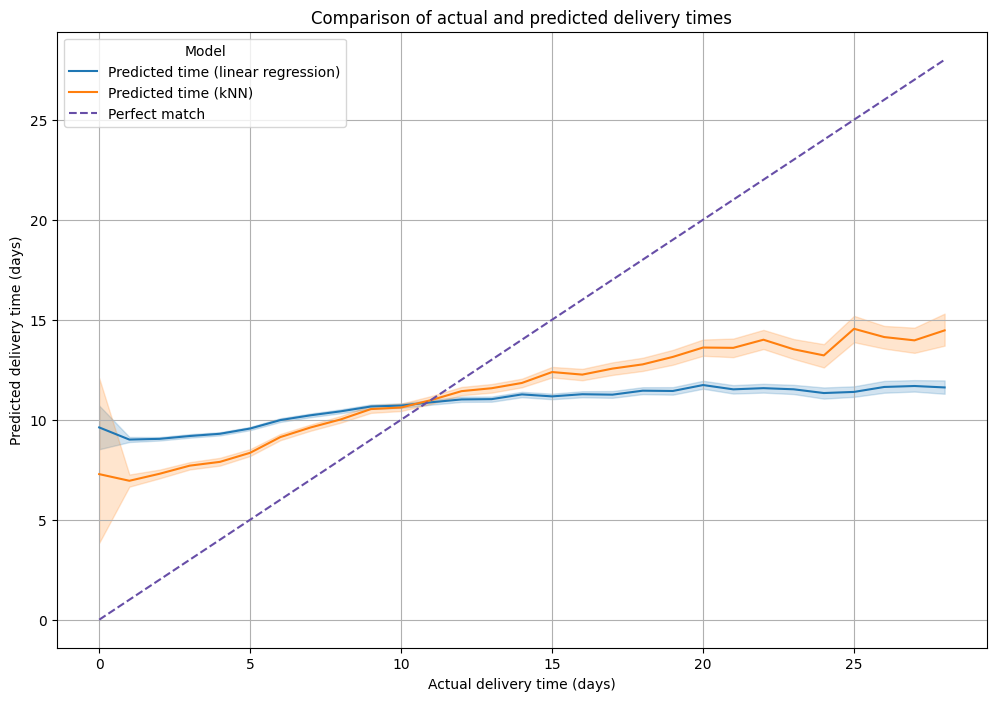

In [99]:
plt.figure(figsize=FIG_SIZE)
sns.lineplot(
    x="Actual time",
    y="Delivery time",
    hue="Model",
    data=results
)
plt.plot(
    [min(y_test), max(y_test)], [min(y_test), max(y_test)],
    label="Perfect match",
    color=MAIN_COLOR,
    linestyle="--"
)
plt.title("Comparison of actual and predicted delivery times")
plt.xlabel("Actual delivery time (days)")
plt.ylabel("Predicted delivery time (days)")
plt.legend(title="Model")
plt.grid(True)
plt.show()

In [100]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = mean_squared_error(y_test, y_pred_knn)

In [101]:
print(
    f"Linear regression model:\n"
    f"MAE = {round(mae_lr, 4)}, R-squared = {round(r2_lr, 4)}, RMSE = {round(rmse_lr, 4)}"
)
print(
    f"kNN model:\n"
    f"MAE = {round(mae_knn, 4)}, R-squared = {round(r2_knn, 4)}, RMSE = {round(rmse_knn, 4)}"
)

Linear regression model:
MAE = 4.5181, R-squared = 0.1203, RMSE = 32.2338
kNN model:
MAE = 4.2297, R-squared = 0.1725, RMSE = 30.3225


In [102]:
param_grid_lr = {"fit_intercept": [True, False]}

param_grid_knn = {"n_neighbors": [3, 5, 7, 9, 11]}

grid_search_lr = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid_lr,
    scoring="neg_mean_squared_error",
    cv=5
)
grid_search_lr.fit(X_train_scaled, y_train)
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

grid_search_knn = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_knn,
    scoring="neg_mean_squared_error",
    cv=5
)
grid_search_knn.fit(X_train_scaled, y_train)
best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_

In [103]:
y_pred_lr = best_model_lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)

y_pred_knn = best_model_knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)

print(f"Linear regression best parameters: {best_params_lr}, MSE = {round(mse_lr, 4)}")
print(f"kNN best parameters: {best_params_lr}, MSE = {round(mse_knn, 4)}")

Linear regression best parameters: {'fit_intercept': True}, MSE = 32.2338
kNN best parameters: {'fit_intercept': True}, MSE = 28.8101


In [104]:
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"])
order_data = pd.merge(orders, order_payments, on="order_id")
order_data.set_index("order_purchase_timestamp", inplace=True)

daily_revenue = order_data.resample("D")["payment_value"].sum().reset_index()
daily_revenue["day_number"] = (
        daily_revenue["order_purchase_timestamp"] - daily_revenue["order_purchase_timestamp"].min()
).dt.days

In [105]:
X = daily_revenue[["day_number"]]
y = daily_revenue["payment_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [106]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Linear regression model: MSE = {round(mse, 4)}, R-squared = {round(r2, 4)}")

Linear regression model: MSE = 186504357.9377, R-squared = 0.2637


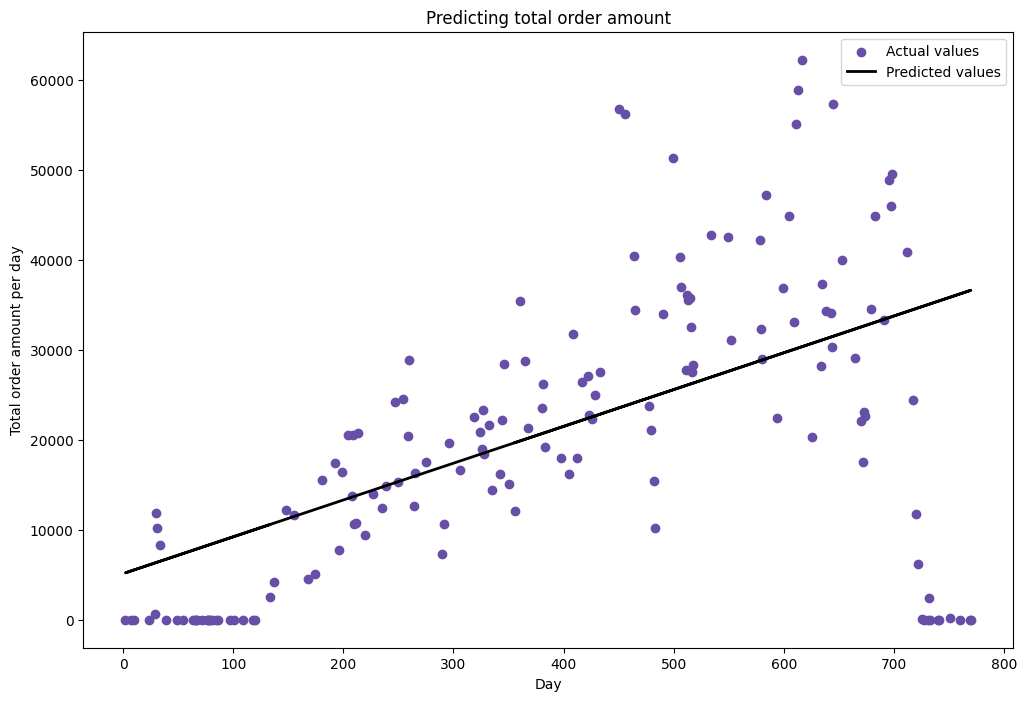

In [107]:
plt.figure(figsize=FIG_SIZE)
plt.scatter(X_test, y_test, color=MAIN_COLOR, label="Actual values")
plt.plot(X_test, y_pred, color="black", linewidth=2, label="Predicted values")
plt.title("Predicting total order amount")
plt.xlabel("Day")
plt.ylabel("Total order amount per day")
plt.legend()
plt.show()

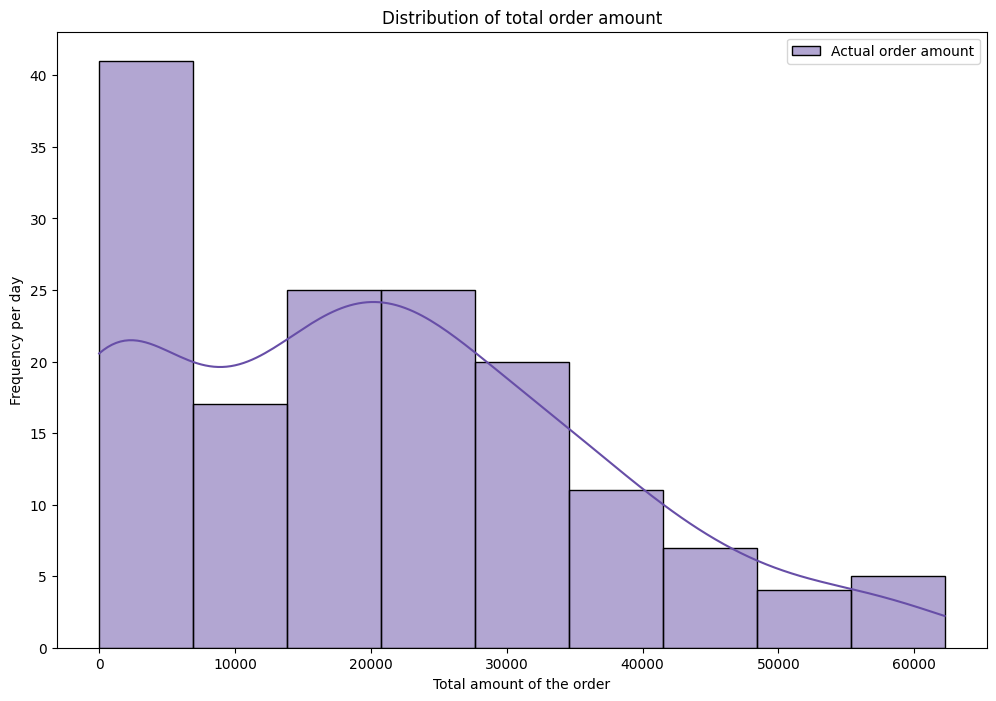

In [108]:
plt.figure(figsize=FIG_SIZE)
sns.histplot(y_test, kde=True, color=MAIN_COLOR, label="Actual order amount")
plt.xlabel("Total amount of the order")
plt.ylabel("Frequency per day")
plt.title("Distribution of total order amount")
plt.legend(loc="upper right")
plt.show()